In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sc
import statsmodels.graphics.gofplots as sm
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

#### Read in data file

In [3]:
data = pd.read_csv("/Users/FM/Public/HDS/Summer Project/wastewater_r_estimation/Linked Data_South West.csv")
data.head()

,Unnamed: 0,date,weighted_avg_sars_cov2,SOUTH WEST_LOWER BOUND,SOUTH WEST_UPPER BOUND,SOUTH WEST_AVERAGE,log_gene
0,0,2020-09-11,97.203367,0.9,1.200000,1.050000,1.987681
1,1,2020-09-12,434.482516,0.9,1.257143,1.078571,2.637972
2,2,2020-09-13,771.761665,0.9,1.314286,1.107143,2.887483
3,3,2020-09-14,4314.181145,0.9,1.371429,1.135714,3.634898
4,4,2020-09-15,3128.723632,0.9,1.428571,1.164286,3.495367


#### Univariable XGBoost Regressor

In [4]:
x = data.iloc[:, 6]
y = data.iloc[:, 5]

In [5]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state = 100)

xg_reg = XGBRegressor()

In [6]:
xg_reg.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [7]:
# Test data
y_pred = xg_reg.predict(x_test)

In [8]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, y_pred)

In [9]:
print("MSE: %0.2f" % (mse))

MSE: 0.07


In [10]:
rmse = np.sqrt(mse)
print ("RMSE: %0.2f" % (rmse))

RMSE: 0.26


In [11]:
from sklearn.model_selection import cross_val_score
model = XGBRegressor(objective = "reg:squarederror")
scores = cross_val_score(model, x, y,
                         scoring = "neg_mean_squared_error",
                         cv = 10)

In [12]:
scores

array([-0.04208063, -0.0788624 , -0.11519254, -0.01041484, -0.05308618,
       -0.08290515, -0.06737025, -0.03541493, -0.07459766, -0.11785801])

In [13]:
rmse = np.sqrt(-scores)
print(rmse)

[0.20513563 0.28082451 0.33940026 0.10205315 0.23040438 0.28793254
 0.25955779 0.18818854 0.27312572 0.34330455]


#### UKHSA Model

In [14]:
sample_variables = ['sars_cov2_gc_l_mean',
                    'suspended_solids_mg_l', 'ammonia_mg_l', 'ophosph_mg_l',
                    'sample_ph_pre_ansis',
                    'control_gc_l_mean','reac_vol_control', # "reac_vol_sars",
                    # 'raw_ansis_sars_repc_1', 'raw_ansis_sars_repc_2',
                    # 'raw_ansis_sars_repc_mean',
                    'raw_ansis_sars_repc_std',
                    'compo_frac',
                    'sars_below_lod', 'sars_below_loq',
                    'reception_delay',
                    #                    'ww_site_code',  # try here?
                    #                     'date',
                    #                   'analysis_lab_code',
                    #'lab_analysis_1.1.1', 'lab_analysis_1.1.2',
                    #'target_gene_N1'
                    ]

site_variables = [
    'catchment_population_ons_mid_2019',
    'catchment_area'
    #                   ,'site_skey',  # numeric so should be ok.
    #                   'ww_site_code',
    #                   'water_company_AE',
    #                   'water_company_AW', 'water_company_NW', 'water_company_ST',
    #                   'water_company_SW', 'water_company_SWS', 'water_company_TW',
    #                   'water_company_UU', 'water_company_WW', 'water_company_WXW',
    #                   'water_company_YW'
]

cis_variables = ['catch_in_cis_prop', 'catch_cis_population'
                 #             ,'cis_population'
                 ]

all_variables = sample_variables + site_variables + cis_variables

In [15]:
dict_models = dict(xgb = XGBRegressor())

model_variables = dict(xgb = 'weighted_avg_sars_cov2')

model_labels = {'xgb': 'Gradient Boosted',
                'process': 'Process-based'}

In [16]:
# Bootstrap predictions
from ml_utils import bootstrap, Dataset

repeat = 50
preds_bootstrap = {}

models = ['xgb'] # remove some models as desired, as RE can be long for example

for model_name in models:
    dataset = Dataset(data.set_index(['date']), model_variables[model_name],
                      'SOUTH WEST_AVERAGE', input_offset=0.001) #'median_prob' refers to prevalence still
    x, y = dataset.prepare_no_split()
    preds_bootstrap[model_name] = bootstrap(dict_models[model_name], x, y, repeat=repeat)

100%|██████████| 50/50 [00:03<00:00, 15.42it/s]


In [17]:
# Computing Mean and SE of errors

dict_pred = {model_name: preds_bootstrap[model_name].mean(1) for model_name in preds_bootstrap}
# dict_pred_natural = {model_name: 10**preds_bootstrap[model_name].mean(1) for model_name in preds_bootstrap}
dict_se = {model_name: pred.std(1)/np.sqrt(repeat - np.isnan(pred).sum(1)) for model_name, pred in preds_bootstrap.items()}
dict_se_natural = {model_name: 10**pred.std(1)/np.sqrt(repeat - np.isnan(pred).sum(1)) for model_name, pred in preds_bootstrap.items()}

mean absolute error 0.0673
median absolute error 0.0544
q95 absolute error 0.1753

Natural space
median relative error 13.0293
q95 relative error 45.6044
median absolute error 14.3626
q95 absolute error 44.2174


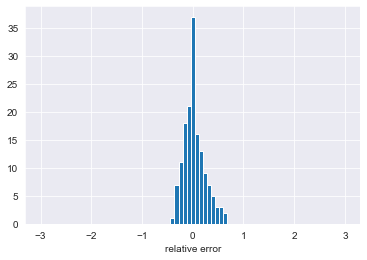

Text(0.5, 0, 'signed error (Re)')

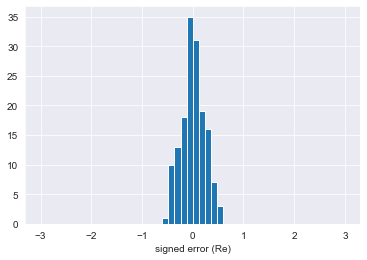

In [21]:
# Error for xgb

print(f'mean absolute error {np.abs((dict_pred[model_name]-y)).mean():.4f}')
print(f'median absolute error {np.abs((dict_pred[model_name]-y)).median():.4f}')
print(f'q95 absolute error {np.quantile(np.abs((dict_pred[model_name]-y)), 0.95):.4f}')

# Natural space
print('\nNatural space')
print(f'median relative error {np.abs((10**dict_pred[model_name]-10**y)/10**y).median()*100:.4f}')
print(f'q95 relative error {np.quantile(np.abs((10**dict_pred[model_name]-10**y)/10**y), 0.95)*100:.4f}')

print(f'median absolute error {np.abs((10**dict_pred[model_name]-10**y)).median()*100:.4f}')
print(f'q95 absolute error {np.quantile(np.abs((10**dict_pred[model_name]-10**y)), 0.95)*100:.4f}')

plt.hist((10**dict_pred[model_name]-10**y)/10**y, 75, range=(-3, 3))
plt.xlabel('relative error')
plt.show()

plt.hist((10**dict_pred[model_name]-10**y), 50, range=(-3,3))
plt.xlabel('signed error (Re)')